In [30]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [31]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [32]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import datasets.Datasets
import models.Feedforward
import models.Attention
import models.DannyCNN
import utils.train

In [33]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [18]:
# For Patch-to-Pixel

# Make datasets and dataloaders

# setup

radius = 0

importlib.reload(datasets.Datasets)

omit_components = 244 - 4

batch_size = 256

base_data_path = 'Data\\CNN_Data\\Splits'


# load data

emit_train = pickle_load(
    os.path.join(base_data_path, 'reflectance_cnn_train_pca244.pkl')
)
emit_val = pickle_load(
    os.path.join(base_data_path, 'reflectance_cnn_val_pca244.pkl')
)

elev_train = pickle_load(
    os.path.join(base_data_path, 'elevation_cnn_train.pkl')
)
elev_val = pickle_load(os.path.join(base_data_path, 'elevation_cnn_val.pkl'))

eco_train = pickle_load(os.path.join(base_data_path, 'temp_cnn_train.pkl'))
eco_val = pickle_load(os.path.join(base_data_path, 'temp_cnn_val.pkl'))


# create datasets and dataloaders

train_dataset = datasets.Datasets.PatchToPixelDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    radius=radius,
)

val_dataset = datasets.Datasets.PatchToPixelDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    radius=radius,
)

if batch_size is not None:
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, drop_last=True
    )
    val_loader = DataLoader(
        dataset=val_dataset, batch_size=batch_size, drop_last=True
    )
else:
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size
    )
    val_loader = DataLoader(
        dataset=val_dataset, batch_size=batch_size
    )

In [28]:
# For CNN

dropout = 0.5

# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)

# model = models.Feedforward.PatchToPixelModel(
#     input_dim=train_dataset.input_dim, radius=radius, dropout_rate=dropout
# )
model = models.Feedforward.LinearModel(input_dim=train_dataset.input_dim)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='none')

model

LinearModel(
  (linear_output): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
importlib.reload(utils.train)

n_epochs = 50

train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)

SyntaxError: invalid syntax (train.py, line 60)

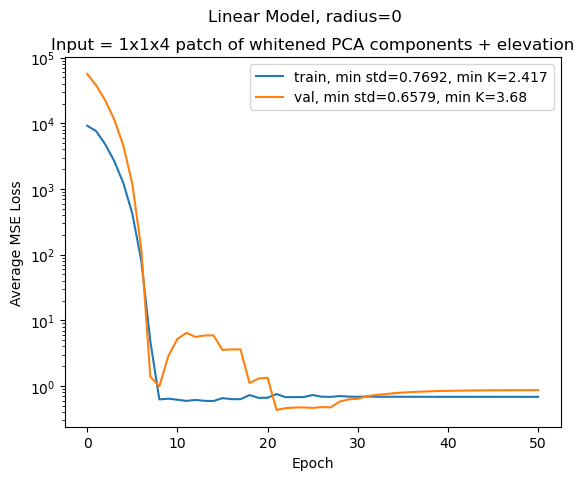

In [21]:
fig, ax = plt.subplots()
fig.suptitle(
    # f'6-Layer Patch-to-Pixel Model, radius={radius}, dropout={dropout}'
    f'Linear Model, radius={radius}'
)
l = 2 * radius + 1
ax.set_title(
    f'Input = {l}x{l}x{244 - omit_components} patch of whitened PCA components'
    ' + elevation'
)
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=(
        'train, '
        # f'min_loss={min(train_loss):.4}, '
        f'min std={min(train_loss)**(1/2):.4}, '
        f'min K={train_dataset.ecostress_scale * min(train_loss)**(1/2):.4}'
    ),
)
ax.semilogy(
    np.arange(len(val_loss)),
    val_loss,
    label=(
        'val, '
        # f'min_loss={min(val_loss):.4}, '
        f'min std={min(val_loss)**(1/2):.4}, '
        f'min K={val_dataset.ecostress_scale * min(val_loss)**(1/2):.4}'
    ),
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)